In [2]:
# library for data manipulation
import numpy as np
import pandas as pd

# library for model creating
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

# library for creating the plots 
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
# import the date set
df = pd.read_csv('price_silver.csv')

In [4]:
# displayt the first 10 values from dataset
df.head(10)

,date,price
0,15.11.2011,12.9086
1,16.11.2011,12.7776
2,17.11.2011,12.9763
3,18.11.2011,12.6169
4,19.11.2011,12.6169
5,20.11.2011,12.6169
6,21.11.2011,12.2145
7,22.11.2011,11.6963
8,23.11.2011,12.0502
9,24.11.2011,11.9659


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4057 entries, 0 to 4056
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    4057 non-null   object 
 1   price   4057 non-null   float64
dtypes: float64(1), object(1)
memory usage: 63.5+ KB


In [6]:
df.describe()

,price
count,4057.000000
mean,10.671349
std,2.108432
min,6.937700
25%,8.935400
50%,9.980500
75%,12.352600
max,16.478100


__The first step when working with time series is to plot and inspect the progression of the series in time.__

Observe that the time series is not stationary: it has a positive trend, some seasonality and a variance that increases with time (heteroskedasticity)

- x = data(date)
- y = price

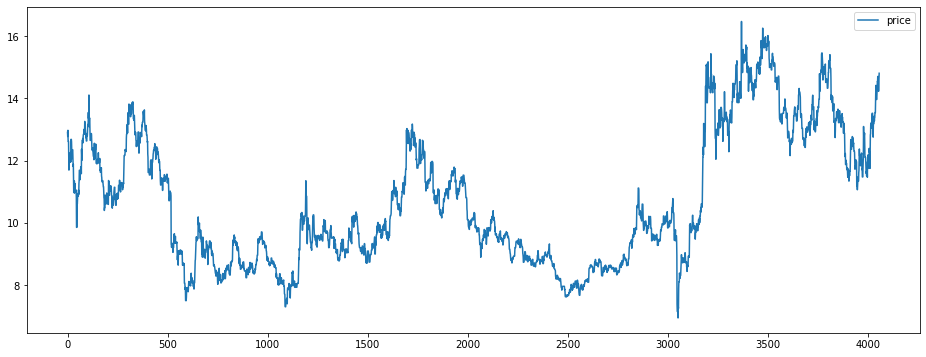

In [7]:
# add axis labels and a title
df.plot(figsize=(16, 6));

### Data Transformations
__Let us take the difference to try and make the time series stationary:__

This line of code is creating a new column in the dataframe (df) named "diff_price" and assigning it the values of the difference of the column "price" in the same dataframe.

In more detail, the diff() function is a pandas function that calculates the difference of a DataFrame element compared to another element in the DataFrame __(by default the element in the previous row)__.

In this case, the diff() function is being applied to the 'price' column of the dataframe. This will calculate the difference between each element in the 'price' column and the previous element, and store the result in a new column called 'diff_price'. This new column will have the same number of rows as the original column but with one less value, because there is no previous value for the first element.

This is used when trying to make a time-series stationary, by calculating the first order difference of the original series, which is subtracted from the original series. This is known as the "differencing" step in time series analysis, and it's a common technique to remove trend and seasonality from a time series to make it stationary.

In [8]:
df['diff_price'] = df['price'].diff()
# df = df.drop("1stdiff", axis='columns')

In [9]:
df.head(10)

,date,price,diff_price
0,15.11.2011,12.9086,NaN
1,16.11.2011,12.7776,-0.1310
2,17.11.2011,12.9763,0.1987
3,18.11.2011,12.6169,-0.3594
4,19.11.2011,12.6169,0.0000
5,20.11.2011,12.6169,0.0000
6,21.11.2011,12.2145,-0.4024
7,22.11.2011,11.6963,-0.5182
8,23.11.2011,12.0502,0.3539
9,24.11.2011,11.9659,-0.0843


Plot the first difference to see if it helped with non-stationarity

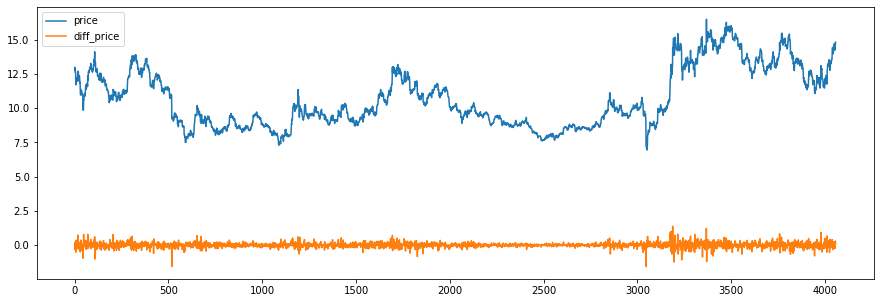

In [17]:
df.plot(figsize=(15, 5));

The first difference helped with the trend, but we can stil see some seasonality and a variance that increases with time.

**A very common transformation with time series data is the log transformation, it helps with non-stationarity issues as well.**

Let's take the log and then plot the data to see if they look more stationary.

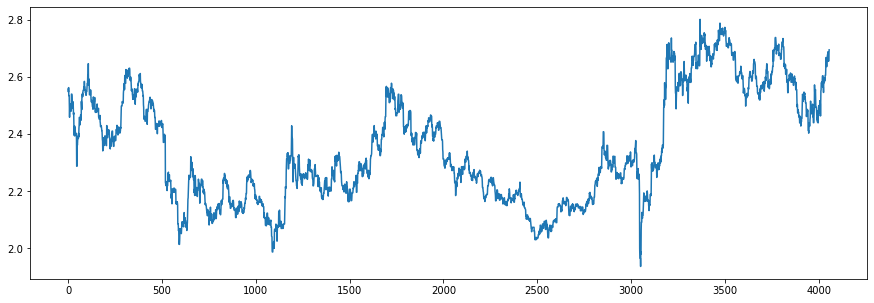

In [12]:
df['LogPrice'] = np.log(df['price'])
df['LogPrice'].plot(figsize=(15, 5));

It appears that the log transformation helped a bit since the variance looks a bit more stable over time, nevetheless there is is still a trend, seasonality and some heteroskedasticity left.

**Let us take the first difference of our logged variable to see if that will help with making the time series stationary.**

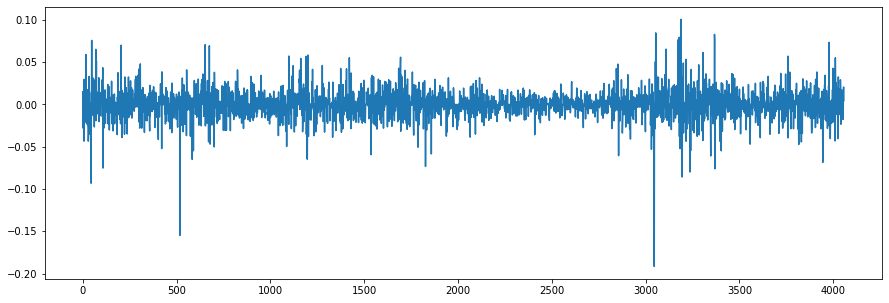

In [13]:
df['LogPrtDiff'] = df['LogPrice'].diff()
df['LogPrtDiff'].plot(figsize=(15, 5));

This looks much closer to a stationary time series. There is still some cyclicality that should be taken care of, but my guess is that when we will fit the ARIMA model using the first difference of the log transformed Passengers, we'll get the best forecasts.

In [14]:
df

,date,price,diff_price,LogPrice,LogPrtDiff
0,15.11.2011,12.9086,NaN,2.557894,NaN
1,16.11.2011,12.7776,-0.1310,2.547694,-0.010200
2,17.11.2011,12.9763,0.1987,2.563125,0.015431
3,18.11.2011,12.6169,-0.3594,2.535037,-0.028087
4,19.11.2011,12.6169,0.0000,2.535037,0.000000
...,...,...,...,...,...
4052,19.12.2022,14.4498,-0.2573,2.670681,-0.017650
4053,20.12.2022,14.2318,-0.2180,2.655479,-0.015202
4054,21.12.2022,14.4422,0.2104,2.670154,0.014676
4055,22.12.2022,14.7436,0.3014,2.690809,0.020655


### Splitting the dataset into the Training set and Test set
Because time series are sequences, we'll take the y values for the last 12 months and assign them to the test set, and the rest will go into the training set.

In the case of df.index.freq = 'MS', it means that the data in the dataframe df is being set to have a monthly frequency. 'MS' stands for "month start" which means that the data will be aligned to the first day of each month. This is useful when working with monthly data and ensures that all the data points fall on the first day of each month.

In [15]:
# error implement corect the month selection
df.index.freq = 'MS'

Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [16]:
train

,date,price,diff_price,LogPrice,LogPrtDiff
0,15.11.2011,12.9086,NaN,2.557894,NaN
1,16.11.2011,12.7776,-0.1310,2.547694,-0.010200
2,17.11.2011,12.9763,0.1987,2.563125,0.015431
3,18.11.2011,12.6169,-0.3594,2.535037,-0.028087
4,19.11.2011,12.6169,0.0000,2.535037,0.000000
...,...,...,...,...,...
4040,07.12.2022,14.4217,0.1869,2.668734,0.013044
4041,08.12.2022,14.0885,-0.3332,2.645359,-0.023375
4042,09.12.2022,13.9693,-0.1192,2.636862,-0.008497
4043,10.12.2022,13.9693,0.0000,2.636862,0.000000


In [17]:
test

,date,price,diff_price,LogPrice,LogPrtDiff
4045,12.12.2022,14.1513,0.1820,2.649806,0.012944
4046,13.12.2022,14.3953,0.2440,2.666902,0.017095
4047,14.12.2022,14.5482,0.1529,2.677467,0.010566
4048,15.12.2022,14.5382,-0.0100,2.676780,-0.000688
4049,16.12.2022,14.7071,0.1689,2.688330,0.011551
4050,17.12.2022,14.7071,0.0000,2.688330,0.000000
4051,18.12.2022,14.7071,0.0000,2.688330,0.000000
4052,19.12.2022,14.4498,-0.2573,2.670681,-0.017650
4053,20.12.2022,14.2318,-0.2180,2.655479,-0.015202
4054,21.12.2022,14.4422,0.2104,2.670154,0.014676


We'll also index the rows in the training and testing set

In [18]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

### Training the ARIMA model on the Training set
First train the naive version of the model where predictions will be made by accounting for y(t) only one period in the past (i.e. y(t-1))

In [19]:
from statsmodels.tsa.arima.model import ARIMA
arima = ARIMA(train['price'], order=(1,0,0))
arima_result = arima.fit()

### Predicting results for the training set
To see first how well the model can fit the data in the training set, create predictions for the rows that went into the training set and save them in the AR(1) column. Later we'll see how well it can forecast into the future (that is how well it can forecast the values from the training set).

In [20]:
df.loc[train_idx, 'AR(1)'] = arima_result.predict(
    start=train.index[0], end=train.index[-1])

Plot the real data in the training set against the model's predictions stored in the AR(1) column

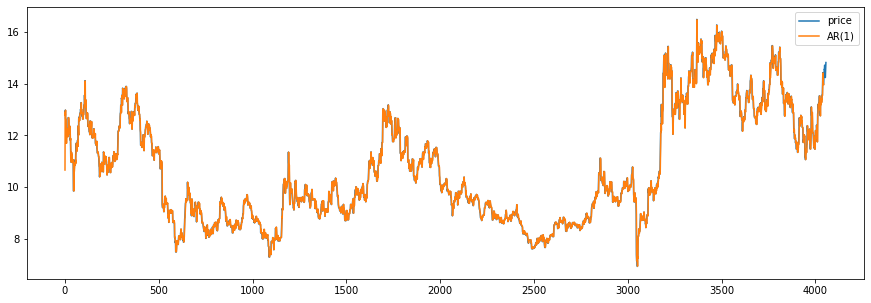

In [21]:
df[['price', 'AR(1)']].plot(figsize=(15, 5));

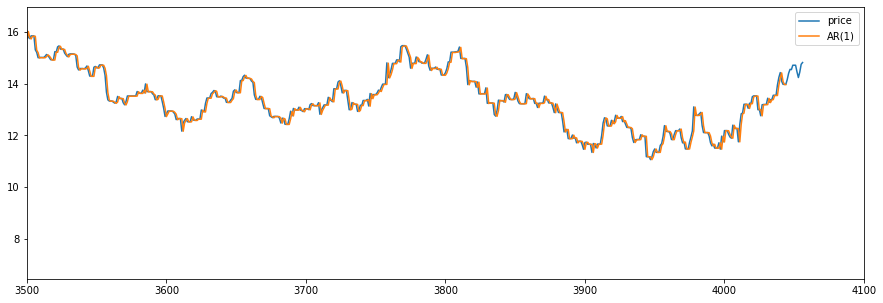

In [22]:
df[['price', 'AR(1)']].plot(figsize=(15, 5));
plt.xlim(3500, 4100)
plt.show()

In [23]:
df

,date,price,diff_price,LogPrice,LogPrtDiff,AR(1)
0,15.11.2011,12.9086,NaN,2.557894,NaN,10.659883
1,16.11.2011,12.7776,-0.1310,2.547694,-0.010200,12.901992
2,17.11.2011,12.9763,0.1987,2.563125,0.015431,12.771377
3,18.11.2011,12.6169,-0.3594,2.535037,-0.028087,12.969493
4,19.11.2011,12.6169,0.0000,2.535037,0.000000,12.611149
...,...,...,...,...,...,...
4052,19.12.2022,14.4498,-0.2573,2.670681,-0.017650,NaN
4053,20.12.2022,14.2318,-0.2180,2.655479,-0.015202,NaN
4054,21.12.2022,14.4422,0.2104,2.670154,0.014676,NaN
4055,22.12.2022,14.7436,0.3014,2.690809,0.020655,NaN


In [24]:
df[['price', 'AR(1)']].head(15)

,price,AR(1)
0,12.9086,10.659883
1,12.7776,12.901992
2,12.9763,12.771377
3,12.6169,12.969493
4,12.6169,12.611149
5,12.6169,12.611149
6,12.2145,12.611149
7,11.6963,12.209931
8,12.0502,11.693254
9,11.9659,12.046114


As expected the model seems to simply mimic the time series by projecting the past values one period back into the future.

In [25]:
# Predicting results for the test set
prediction_result = arima_result.get_forecast(Ntest)
forecast = prediction_result.predicted_mean
df.loc[test_idx, 'AR(1)'] = forecast

Plot the forecasts:

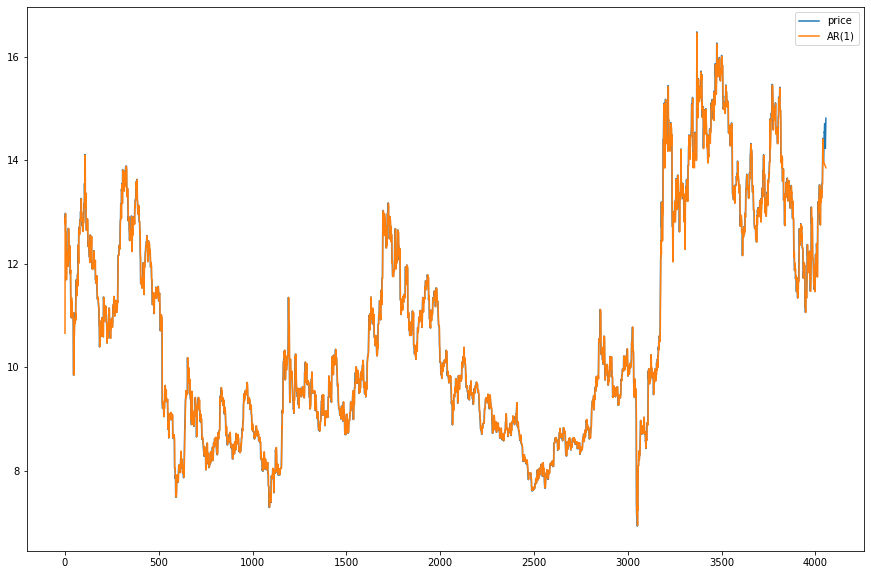

In [26]:
df[['price', 'AR(1)']].plot(figsize=(15, 10));

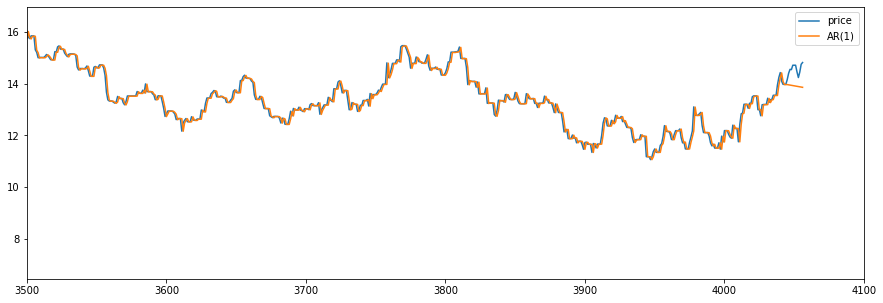

In [27]:
df[['price', 'AR(1)']].plot(figsize=(15, 5));
plt.xlim(3500, 4100)
plt.show()

The forecasts don't look very good even though the model predictions seemed to follow the true time series pretty close. This is what one would expect to see with a naive forecaster (it will mimic the data in the training set, but will not be able to make good forecasts).

#Exploring the predictions further

Let us look at and plot the confidence intervals for our forecasts. This will give us an idea of how precise our forcasts are (narrower confidence intervals-> better forecasts).

In [28]:
prediction_result.conf_int()

,lower price,upper price
4045,13.635454,14.283695
4046,13.492176,14.407580
4047,13.380463,14.499955
4048,13.285178,14.575961
4049,13.200444,14.641472
4050,13.123246,14.699503
4051,13.051787,14.751852
4052,12.984895,14.799689
4053,12.921757,14.843829
4054,12.861776,14.884867


- erorare absolut
- eroare relativă
- eroare maximă - L1 error

In [29]:
def plot_fit_and_forecast(result):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(df['price'], label='data')
    
    # plot the curve fitted on train set
    train_pred = result.fittedvalues
    ax.plot(train.index, train_pred, color='green', label='fitted')

    # forecast the test set
    prediction_result = result.get_forecast(Ntest)
    conf_int = prediction_result.conf_int()
    lower, upper = conf_int['lower price'], conf_int['upper price']
    forecast = prediction_result.predicted_mean
    ax.plot(test.index, forecast, label='forecast')
    ax.fill_between(test.index, \
                  lower, upper, \
                  color='red', alpha=0.3)
    ax.legend()

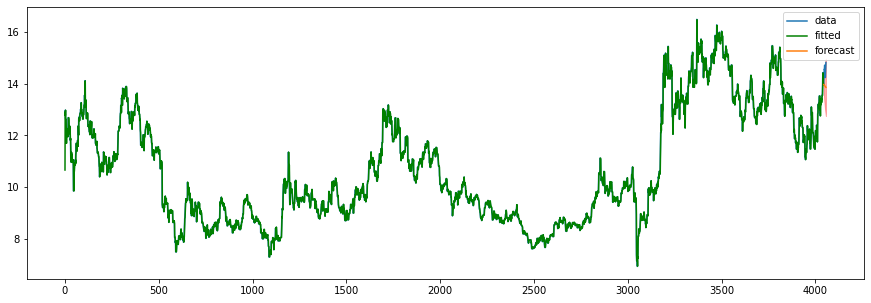

In [30]:
plot_fit_and_forecast(arima_result)

(4000.0, 4070.0)

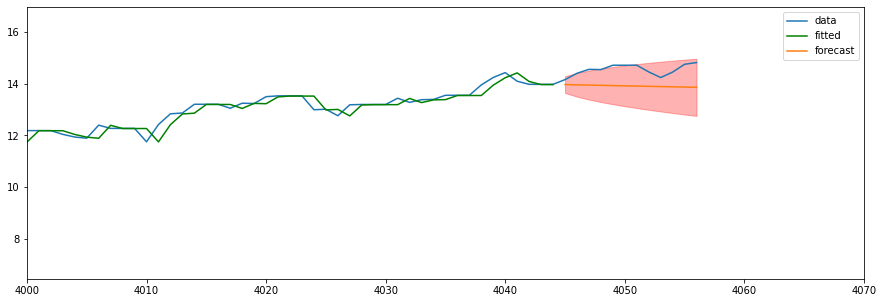

In [31]:
plot_fit_and_forecast(arima_result)
plt.xlim(4000, 4070)

The confidence intervals are large, as would be expected with such forecasts.
Let us explore other model configurations

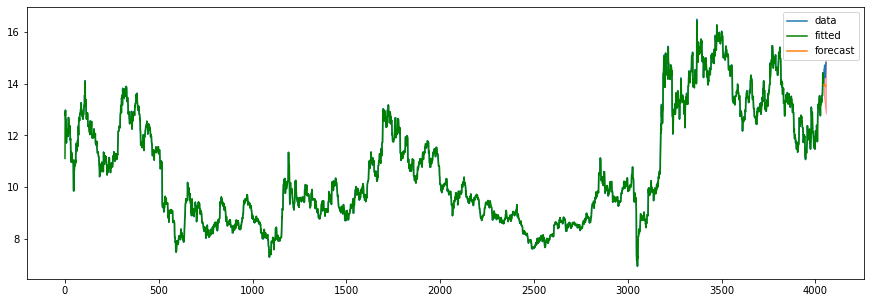

In [32]:
arima = ARIMA(train['price'], order=(10, 0, 0)) # AR(10)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)

(4000.0, 4070.0)

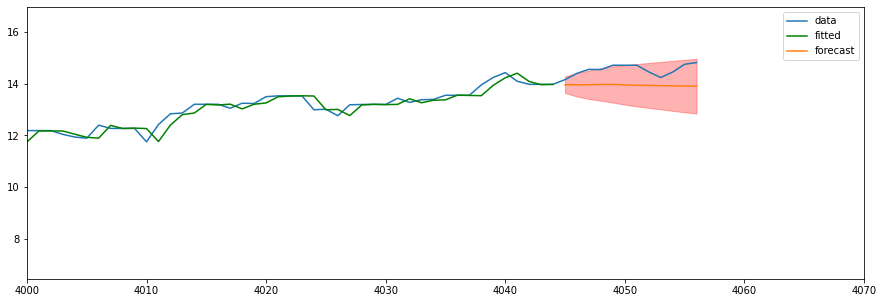

In [33]:
arima = ARIMA(train['price'], order=(10, 0, 0)) # AR(10)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)
plt.xlim(4000, 4070)

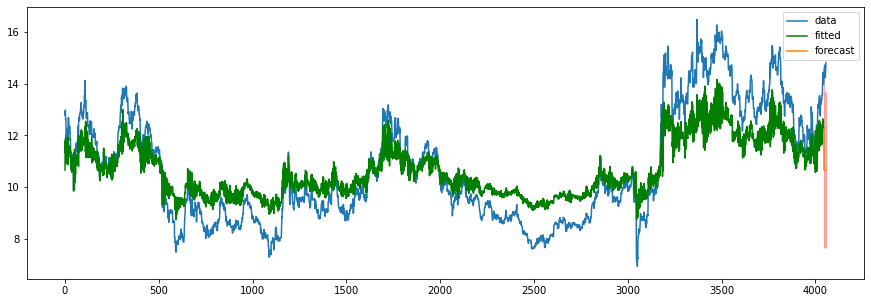

In [34]:
arima = ARIMA(train['price'], order=(0,0,1)) # MA(1)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)

(4000.0, 4070.0)

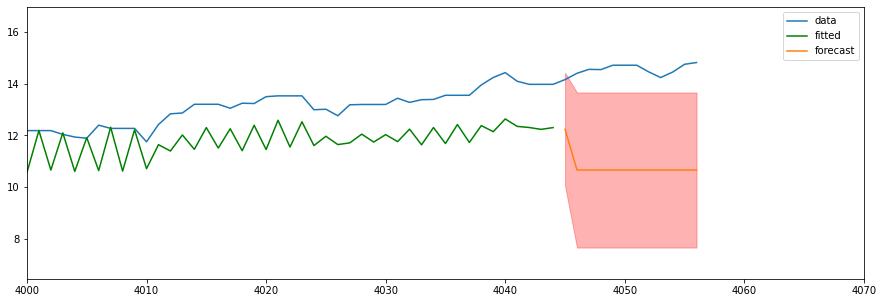

In [35]:
arima = ARIMA(train['price'], order=(0,0,1)) # MA(1)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)
plt.xlim(4000, 4070)

The MA (1) doesn't seem to be making a good job.
MA stands for "Moving Average" and it is a statistical technique used in time series analysis and forecasting.

The model below ARIMA (8,1,1) - will take the first difference of y(t). The nice thing about using ARIMA models is that you don't have to 'undo' the differencing when making predictions (if you are using classical ML models, and your data is non-stationary and you use the differencing method, you will need to transform your data back when making predictions).

In [36]:
arima = ARIMA(train['price'], order=(8,1,1)) #ARIMA (8,1,1) - will take the first difference of 
arima_result_811 = arima.fit()

We'll need to write out again the code for the plot because now after differencing we'll be missing the first row and will need to use the plot_fit_and_forecast_int function.

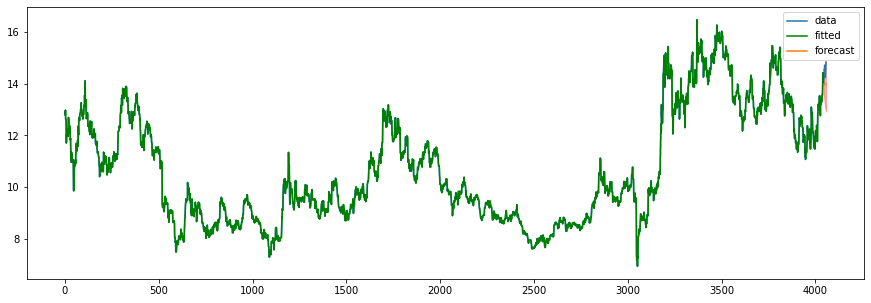

In [37]:
def plot_fit_and_forecast_int(result, d, col='price'):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(df[col], label='data')

    # plot the curve fitted on train set
    train_pred = result.predict(start=train.index[d], end=train.index[-1])
    ax.plot(train.index[d:], train_pred, color='green', label='fitted')

    # forecast the test set
    prediction_result = result.get_forecast(Ntest)
    conf_int = prediction_result.conf_int()
    lower, upper = conf_int[f'lower {col}'], conf_int[f'upper {col}']
    forecast = prediction_result.predicted_mean
    ax.plot(test.index, forecast, label='forecast')
    ax.fill_between(test.index, \
                  lower, upper, \
                  color='red', alpha=0.3)
    ax.legend()

plot_fit_and_forecast_int(arima_result_811, 1)

(4000.0, 4070.0)

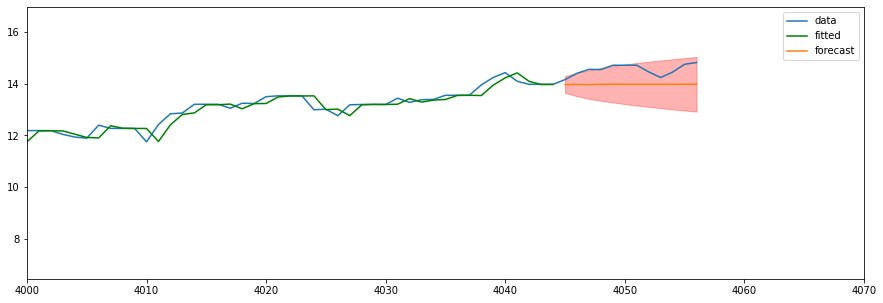

In [38]:
def plot_fit_and_forecast_int(result, d, col='price'):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(df[col], label='data')

    # plot the curve fitted on train set
    train_pred = result.predict(start=train.index[d], end=train.index[-1])
    ax.plot(train.index[d:], train_pred, color='green', label='fitted')

    # forecast the test set
    prediction_result = result.get_forecast(Ntest)
    conf_int = prediction_result.conf_int()
    lower, upper = conf_int[f'lower {col}'], conf_int[f'upper {col}']
    forecast = prediction_result.predicted_mean
    ax.plot(test.index, forecast, label='forecast')
    ax.fill_between(test.index, \
                  lower, upper, \
                  color='red', alpha=0.3)
    ax.legend()

plot_fit_and_forecast_int(arima_result_811, 1)
plt.xlim(4000, 4070)

These predictions look best than anything we have seen before, and it makes sense since we saw that the first difference removes the trend.

__Let us try now the logged version and see if this will give us maybe even better results__

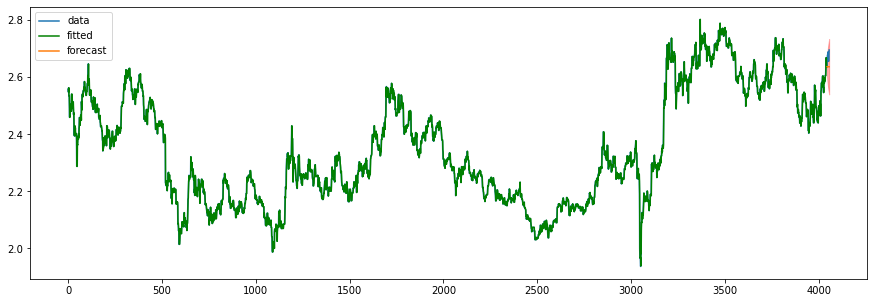

In [39]:
arima = ARIMA(train['LogPrice'], order=(8,1,1)) #ARIMA(8,1,1)log
arima_result_log811 = arima.fit()
plot_fit_and_forecast_int(arima_result_log811, 1, col='LogPrice')

(4000.0, 4070.0)

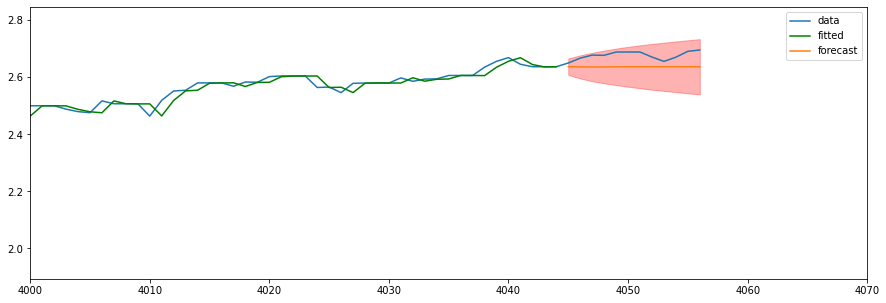

In [40]:
arima = ARIMA(train['LogPrice'], order=(8,1,1)) #ARIMA(8,1,1)log
arima_result_log811 = arima.fit()
plot_fit_and_forecast_int(arima_result_log811, 1, col='LogPrice')
plt.xlim(4000, 4070)

ARIMA(8,1,1)log seems marginally better. The model seems to create forecasts that predict better the peaks. Also the confidence intervals now include the peak. 


**NOTE:** in this graph you see the logged versions of both the true y values and the predictions. If you are interested in the actual numerical predictions, you will have to undo the log transformation. 

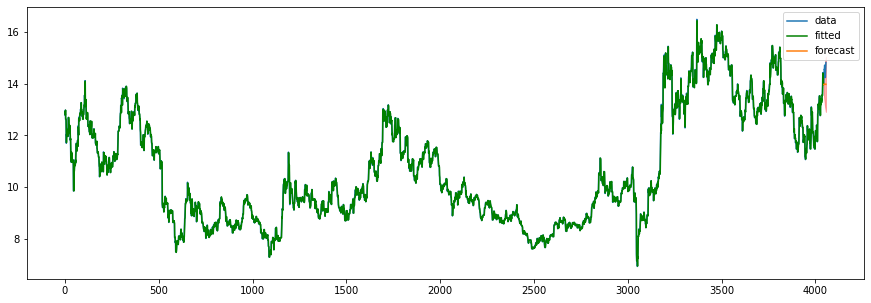

In [41]:
arima = ARIMA(train['price'], order=(12,1,0)) #ARIMA(12,1,0)
arima_result_1210 = arima.fit()
plot_fit_and_forecast_int(arima_result_1210, 1, col='price')

(4000.0, 4070.0)

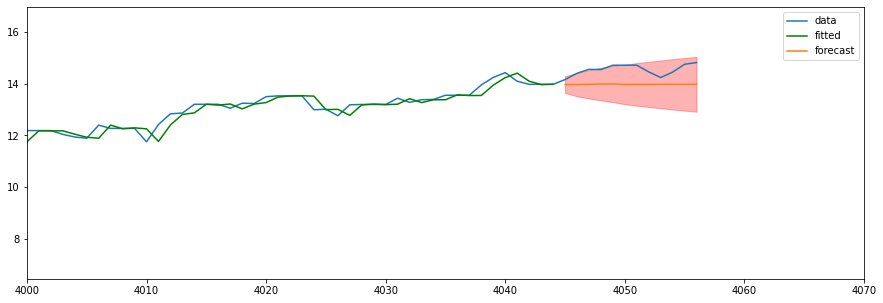

In [42]:
arima = ARIMA(train['price'], order=(12,1,0)) #ARIMA(12,1,0)
arima_result_1210 = arima.fit()
plot_fit_and_forecast_int(arima_result_1210, 1, col='price')
plt.xlim(4000, 4070)

ARIMA(12,1,0) appears to give the best forcasts for now.

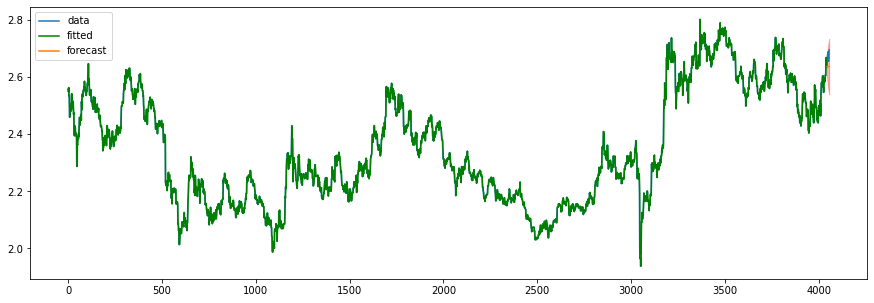

In [43]:
arima = ARIMA(train['LogPrice'], order=(12,1,0))
arima_result_log1210 = arima.fit()
plot_fit_and_forecast_int(arima_result_log1210, 1, col='LogPrice')

(4000.0, 4070.0)

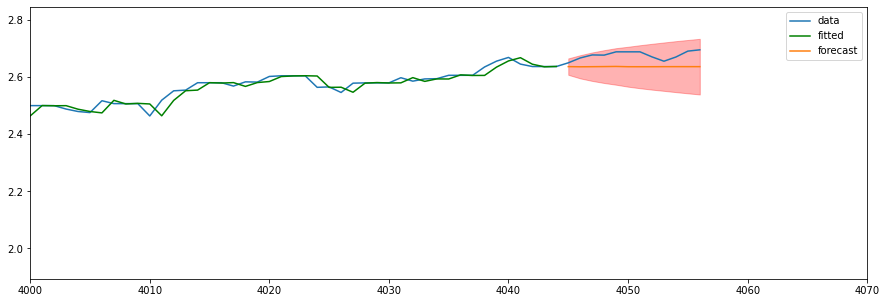

In [44]:
arima = ARIMA(train['LogPrice'], order=(12,1,0))
arima_result_log1210 = arima.fit()
plot_fit_and_forecast_int(arima_result_log1210, 1, col='LogPrice')
plt.xlim(4000, 4070)

ARIMA(12,1,0)log seems to fit the data best.

#Computing the goodness of fit of the models

In [45]:
def rmse(result, is_logged):
    forecast = result.forecast(Ntest)
    if is_logged:
        forecast = np.exp(forecast)
  
    t = test['price']
    y = forecast
    return np.sqrt(np.mean((t - y)**2))

RMSE - root mean squered error

RMSE = sqrt(MSE) = sqrt( (1/n) * ∑(predicted_i - actual_i)^2 )

Where:

predicted_i is the predicted value for observation i
actual_i is the actual value for observation i
n is the total number of observations

In [46]:
# RMSE - root mean squered error
print("ARIMA(8,1,1):", rmse(arima_result_811, False))
print("ARIMA(8,1,1) logged:", rmse(arima_result_log811, True))
print("ARIMA(12,1,0):", rmse(arima_result_1210, False))
print("ARIMA(12,1,0) logged:", rmse(arima_result_log1210, True))

ARIMA(8,1,1): 0.6010850166749051
ARIMA(8,1,1) logged: 0.606180177453837
ARIMA(12,1,0): 0.6001961636951055
ARIMA(12,1,0) logged: 0.606801877590491


As expected, the last model ARIMA(12,1,0)log seems to be offering the best forecasts and the lowests root mean squared errors.

#Alternatives

One could use the ACF, PACF and the ADF test to find the hyper parameters for ARIMA(p,d,q)
One could use Auto-ARIMA for the parameters to be found through step iterations based on an information crterion like AIC or BIC.

# second part

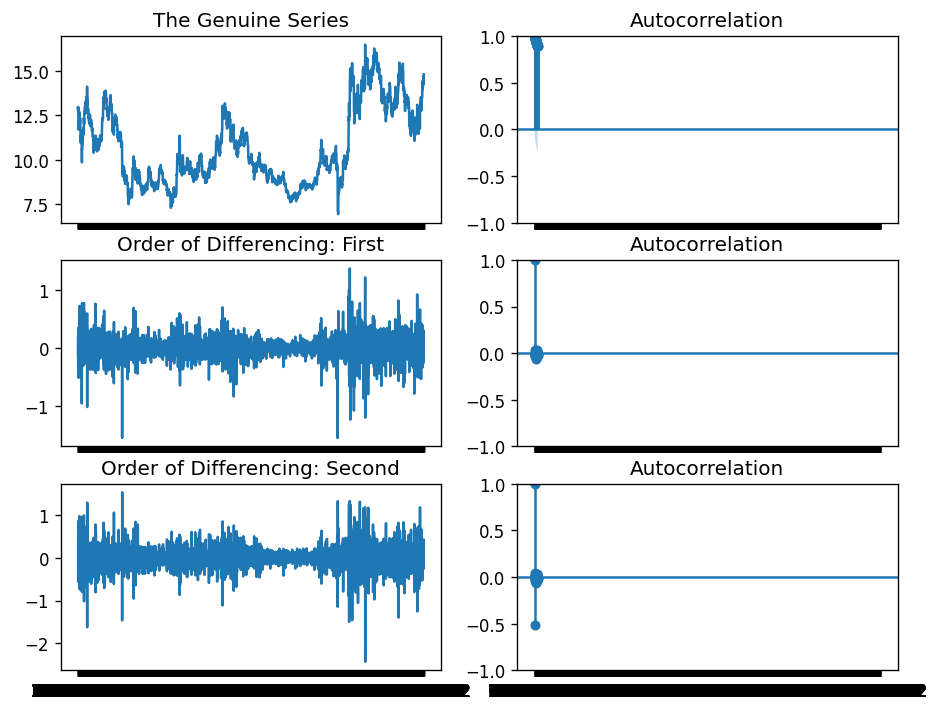

In [127]:
import numpy as np, pandas as pd  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  
import matplotlib.pyplot as plt  
  
plt.rcParams.update({'figure.figsize' : (9,7), 'figure.dpi' : 120})  
  
# Importing data  
df = pd.read_csv('price_silver.csv', names = ['price'], header = 0)  
  
# The Genuine Series  
fig, axes = plt.subplots(3, 2, sharex = True)  
axes[0, 0].plot(df['price']); axes[0, 0].set_title('The Genuine Series')  
plot_acf(df['price'], ax = axes[0, 1])  
  
# Order of Differencing: First  
axes[1, 0].plot(df['price'].diff()); axes[1, 0].set_title('Order of Differencing: First')  
plot_acf(df['price'].diff().dropna(), ax = axes[1, 1])  
  
# Order of Differencing: Second  
axes[2, 0].plot(df['price'].diff().diff()); axes[2, 0].set_title('Order of Differencing: Second')  
plot_acf(df['price'].diff().diff().dropna(), ax = axes[2, 1])  
  
plt.show()  

For those who don’t understand the difference between average and rolling average, a 10-day rolling average would average out the closing prices for the first 10 days as the first data point. The next data point would drop the earliest price, add the price on day 11 and take the average, and so on as shown below.

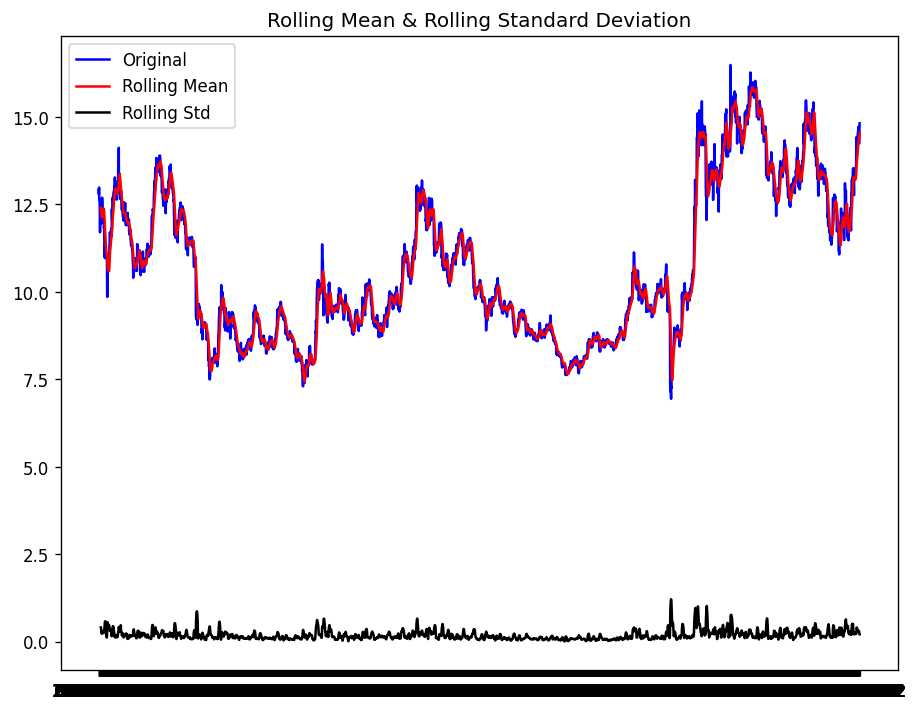

In [130]:
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

As wee can see, the rolling mean and rolling standard deviation increase with time. Therefore, we can conclude that the time series is not stationary.

The ADF Statistic is far from the critical values and the p-value is greater than the threshold (0.05). Thus, we can conclude that the time series is not stationary.

In [134]:
result = adfuller(df['price'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -2.1500197461048987
p-value: 0.22488253269767394
Critical Values:
	1%: -3.4319636730977967
	5%: -2.862253032448362
	10%: -2.567149554309502


Taking the log of the dependent variable is as simple way of lowering the rate at which rolling mean increases.

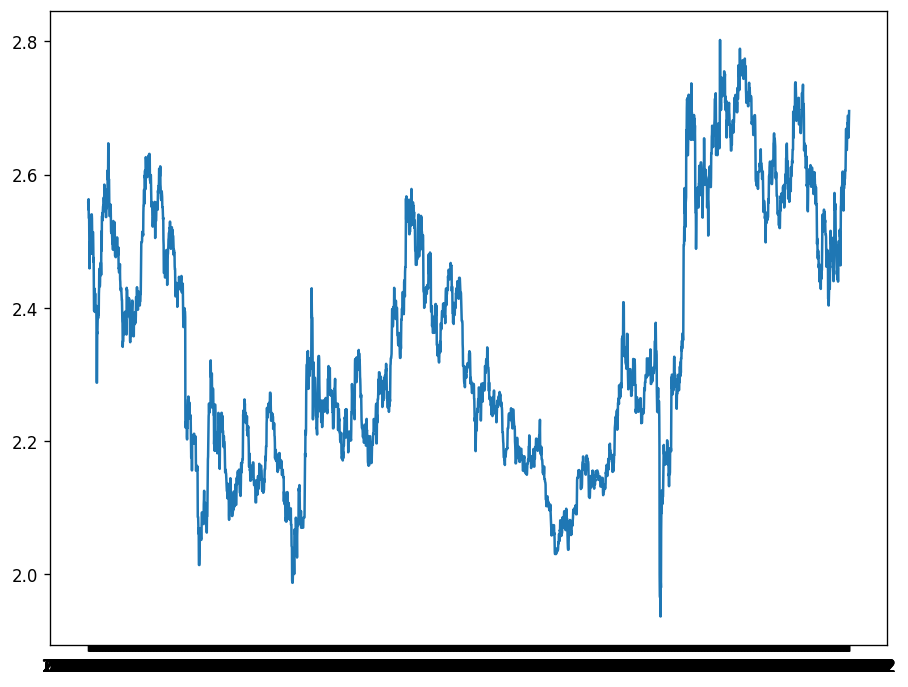

In [147]:
df_log = np.log(df)
plt.plot(df_log)

Let’s create a function to run the two tests which determine whether a given time series is stationary.

In [148]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['price'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

There are multiple transformations that we can apply to a time series to render it stationary. For instance, we subtract the rolling mean.

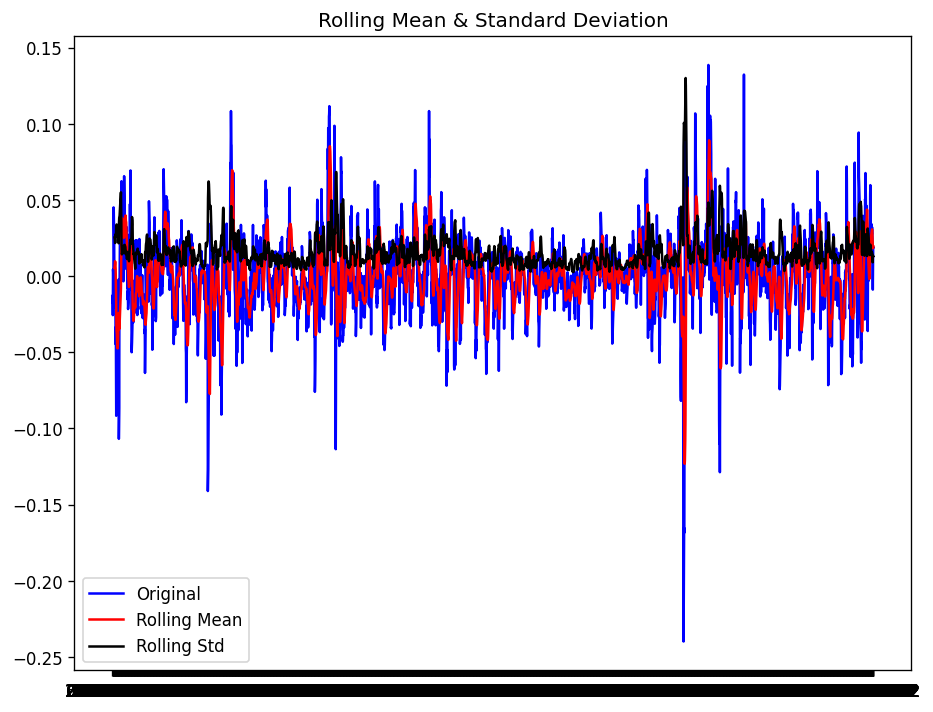

ADF Statistic: -12.61327032949019
p-value: 1.637586597826683e-23
Critical Values:
	1%: -3.4319777314769095
	5%: -2.862259242714302
	10%: -2.567152860387119


In [149]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

As we can see, after subtracting the mean, the rolling mean and standard deviation are approximately horizontal. The p-value is below the threshold of 0.05 and the ADF Statistic is close to the critical values. Therefore, the time series is stationary.

Applying exponential decay is another way of transforming a time series such that it is stationary.

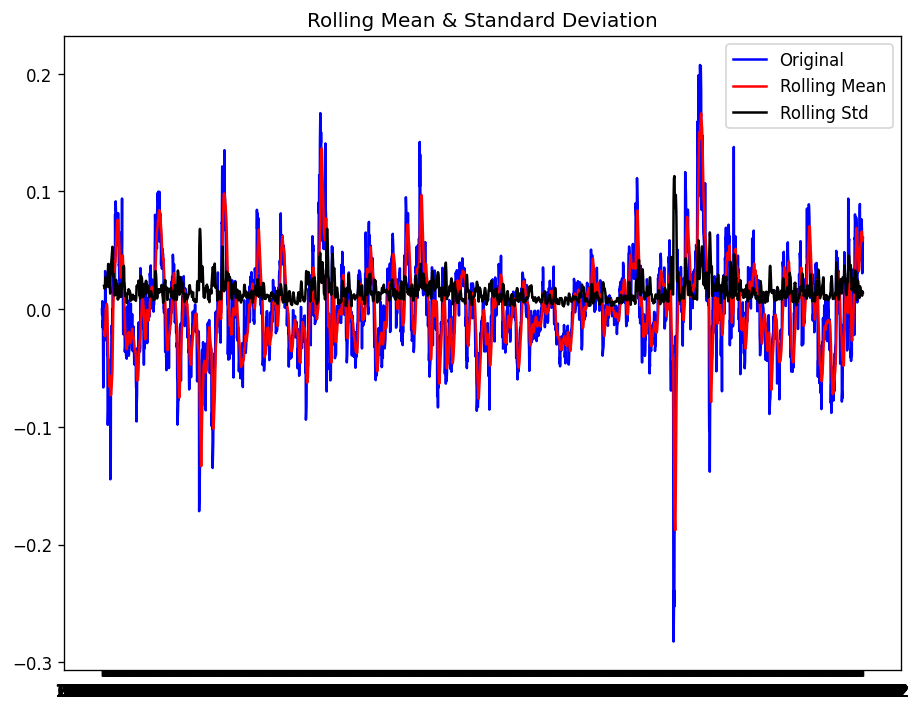

ADF Statistic: -11.253170732820669
p-value: 1.6922260488047035e-20
Critical Values:
	1%: -3.431963274997184
	5%: -2.8622528565876424
	10%: -2.567149460688915


In [150]:
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

Exponential decay performed worse than subtracting the rolling mean. However, it is still more stationary than the original.

Let’s try one more method to determine whether an even better solution exists. When applying time shifting, we subtract every the point by the one that preceded it.

null, (x1−x0), (x2−x1), (x3−x2), (x4−x3), …, (xn−xn−1)

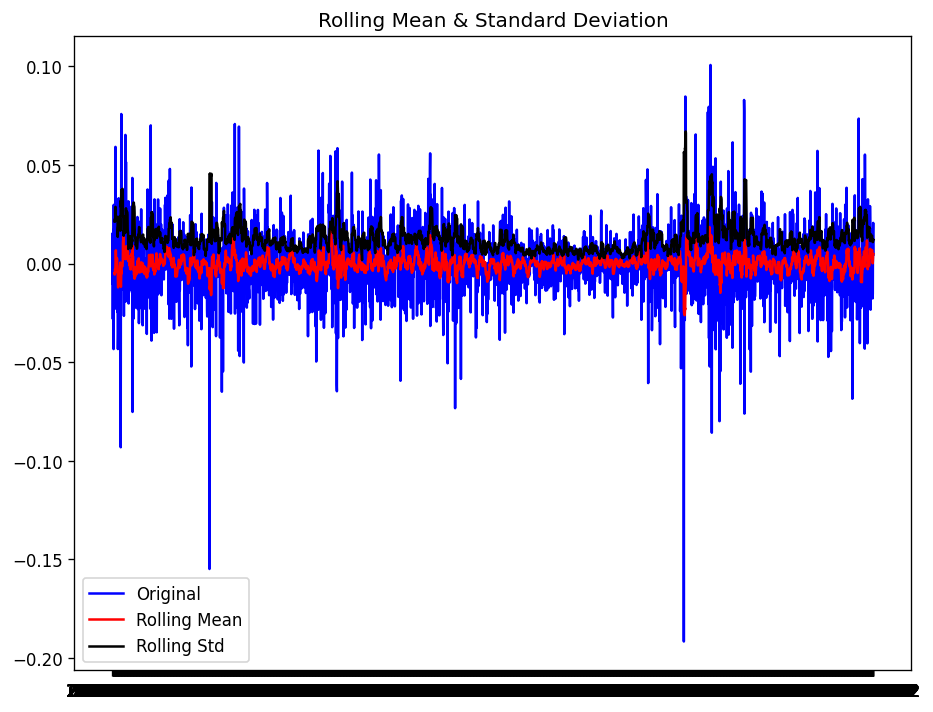

ADF Statistic: -63.715512097764595
p-value: 0.0
Critical Values:
	1%: -3.4319636730977967
	5%: -2.862253032448362
	10%: -2.567149554309502


In [151]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace = True)
get_stationarity(df_log_shift)